# FlexCNN Medical Physics - Notebook Template

This notebook demonstrates how to use the modular parameter system for FlexCNN.

**Key Features:**
- Import default parameters from `user_params.py`
- Override specific parameters without modifying source files
- Rebuild configurations after parameter changes
- Reload package code without kernel restart using `reload_package()`

## Setup Environment

In [1]:
import os
import sys
import shutil

def _detect_colab():
    try:
        import google.colab  # noqa: F401
        return True
    except ImportError:
        return False

IN_COLAB = _detect_colab()

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # Local directory for module access
    local_project_dir = "/content/Colab/Working"
    os.makedirs(local_project_dir, exist_ok=True)

    # Drive mount location
    drive_project_dir = "/content/drive/MyDrive/Colab/Working"

    # Copy modules from Drive to local
    for filename in ("build_dicts.py", "script_setup.py", "user_params.py"):
        src = os.path.join(drive_project_dir, filename)
        dst = os.path.join(local_project_dir, filename)
        if os.path.isfile(src):
            shutil.copy2(src, dst)

    # Add local directory to sys.path
    if local_project_dir not in sys.path:
        sys.path.insert(0, local_project_dir)
else:
    project_dir = os.getcwd()
    if project_dir not in sys.path:
        sys.path.insert(0, project_dir)

from script_setup import (
    sense_colab, sense_device, install_packages,
    setup_colab_environment, setup_local_environment,
    reload_package, refresh_repo
)

IN_COLAB = sense_colab()
print(f"Running in {'Colab' if IN_COLAB else 'Local'} environment")


# Setup environment (run once per session)
install_packages(IN_COLAB, ray_version=None)

if IN_COLAB:
    setup_colab_environment(
        github_username='petercl8',
        repo_name='FlexCNN_for_Medical_Physics',
        skip_git_update=False,
        force_fresh_clone=False  # Set to True if you get import errors after updating GitHub
    )
else:
    # Local setup - use 'walk' mode for fast reload
    setup_local_environment(
        repo_name='FlexCNN_for_Medical_Physics',
        mode='walk',
    )
# Test resources (function now available in global namespace)
list_compute_resources()

Running in Local environment
🖥️  Local environment detected. Installing CUDA-enabled PyTorch...
📦 Installing PyTorch with CUDA (cu124)...
✅ PyTorch installation complete.
📦 Installing other packages...
✅ Other packages installation complete.

CUDA Diagnostic Information:
✅ PyTorch version: 2.6.0+cu124
✅ CUDA available: True
✅ CUDA device count: 1
   GPU 0: NVIDIA GeForce RTX 3080 Ti Laptop GPU

📂 Added C:\Users\Peter Lindstrom\Desktop\FlexCNN_for_Medical_Physics to sys.path
📦 Loading FlexCNN_for_Medical_Physics package (walk mode)...


C:\Users\Peter Lindstrom\AppData\Local\Programs\Python\Python312\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✨ Injecting all symbols into global namespace...
✅ Setup complete: 252 symbols loaded into globals.
CPUs available: 20
GPUs available: 1
  GPU 0: NVIDIA GeForce RTX 3080 Ti Laptop GPU


## Load Default Parameters

In [2]:
# Import after environment setup (build_dicts depends on package being importable)
from build_dicts import build_all_dicts
from USER_PARAMS import get_params

# Get default parameters
params = get_params()

# Display some key parameters
print(f"Run mode: {params['run_mode']}")
print(f"Network type: {params['network_type']}")
print(f"Train SI: {params['train_SI']}")
print(f"Gen sino size: {params['gen_sino_size']}")
print(f"Gen image size: {params['gen_image_size']}")

Run mode: train
Network type: ACT
Train SI: True
Gen sino size: 256
Gen image size: 180


## Setup Paths and Device

In [3]:
# Set main project directory (function available from environment setup)
project_dirPath = params['project_dirPath'] = setup_project_dirs(
    IN_COLAB,
    params['project_local_dirPath'],
    params['project_colab_dirPath'],
    mount_colab_drive=True
)

# Set device
device = params['device_opt'] = sense_device(device=params['device_opt'])

print(f"Project directory: {project_dirPath}")
print(f"Device: {device}")

Project directory: C:\Users\Peter Lindstrom\Desktop\FlexCNN_for_Medical_Physics\project\working
Device: cuda


## Build Configuration Dictionaries

In [4]:
# Build all dictionaries
all_dicts = build_all_dicts(params)

# Extract main dictionaries
config = all_dicts['config']
paths = all_dicts['paths']
settings = all_dicts['settings']
base_dirs = all_dicts['base_dirs']
tune_opts = all_dicts['tune_opts']
test_opts = all_dicts['test_opts']

print("✅ Configuration dictionaries built successfully!")
print(f"Config keys: {list(config.keys())}")

[SETUP_SETTINGS DEBUG - TRAIN] Setting augment to: ('SI', True)

[AUGMENT DEBUG] run_mode=train, network_type=ACT
[AUGMENT DEBUG] settings['augment']=('SI', True)
[AUGMENT DEBUG] Expected augment from params: train_augment=('SI', True)

✅ Configuration dictionaries built successfully!
Config keys: ['SI_alpha_min', 'SI_dropout', 'SI_exp_kernel', 'SI_fixedScale', 'SI_gen_fill', 'SI_gen_final_activ', 'SI_gen_hidden_dim', 'SI_gen_mult', 'SI_gen_neck', 'SI_gen_z_dim', 'SI_half_life_examples', 'SI_layer_norm', 'SI_learnedScale_init', 'SI_normalize', 'SI_output_scale_lr_mult', 'SI_pad_mode', 'SI_skip_mode', 'SI_stats_criterion', 'batch_base2_exponent', 'gen_b1', 'gen_b2', 'gen_image_channels', 'gen_image_size', 'gen_lr', 'gen_sino_channels', 'gen_sino_size', 'network_type', 'sup_base_criterion', 'train_SI']


# Tensorboard

In [5]:
# 2️⃣ Set the folder containing your experiment runs
log_folder = "working/searches/search-ACT-256-bilinear-largePadSinos-fill_1-tunedSSIM"

# 3️⃣ Reload TensorBoard extension (safe if already loaded)
%reload_ext tensorboard

# 4️⃣ Launch TensorBoard inline with taller display
%tensorboard --logdir {log_folder}

Reusing TensorBoard on port 6006 (pid 26676), started 12:55:14 ago. (Use '!kill 26676' to kill it.)

# Scales

In [6]:
#avg_activity = compute_average_activity_per_image(paths, dataset='train')
#scales1 = compute_quantitative_reconstruction_scale(paths, dataset='train', compute_sinogram_scale=False)
#scales2 = analyze_reconstruction_scale_distribution(paths, dataset='train', sample_mode='full', sample_size=1000, ratio_cap_multiple=None)
#sinogram_scale = compute_sinogram_to_image_scale(paths, dataset='train', sample_number=1000)

# Sinogram Alignment

## Pre-generated

Shape: torch.Size([7, 1, 180, 180]) // Min: 0.0 // Max: 450.765625         // Mean: 25.537660598754883 // Mean Sum (per image): 827420.2142857143 // Sum (a single image): 941304.5
Shape: torch.Size([7, 1, 180, 180]) // Min: 0.0 // Max: 202.99185180664062         // Mean: 27.61421775817871 // Mean Sum (per image): 894700.6428571428 // Sum (a single image): 1046343.9375


C:\Users\Peter Lindstrom\AppData\Local\Temp\ipykernel_8104\2445743256.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  act_sino = torch.from_numpy(np.load(os.path.join(paths['data_dirPath'], 'train-highCountSino-180x180.npy'), mmap_mode='r'))[indexes,1,:,:].unsqueeze(dim=1)*settings['act_sino_scale']


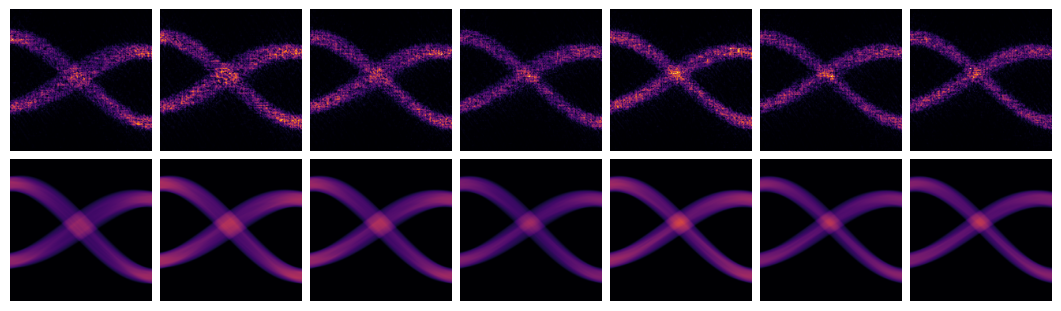

Shape: torch.Size([7, 1, 180, 180]) // Min: 0.0 // Max: 631.3580932617188 // Mean: 53.151878356933594 // Mean Sum (per image): 1722120.857142857 // Sum (a single image): 1987648.5


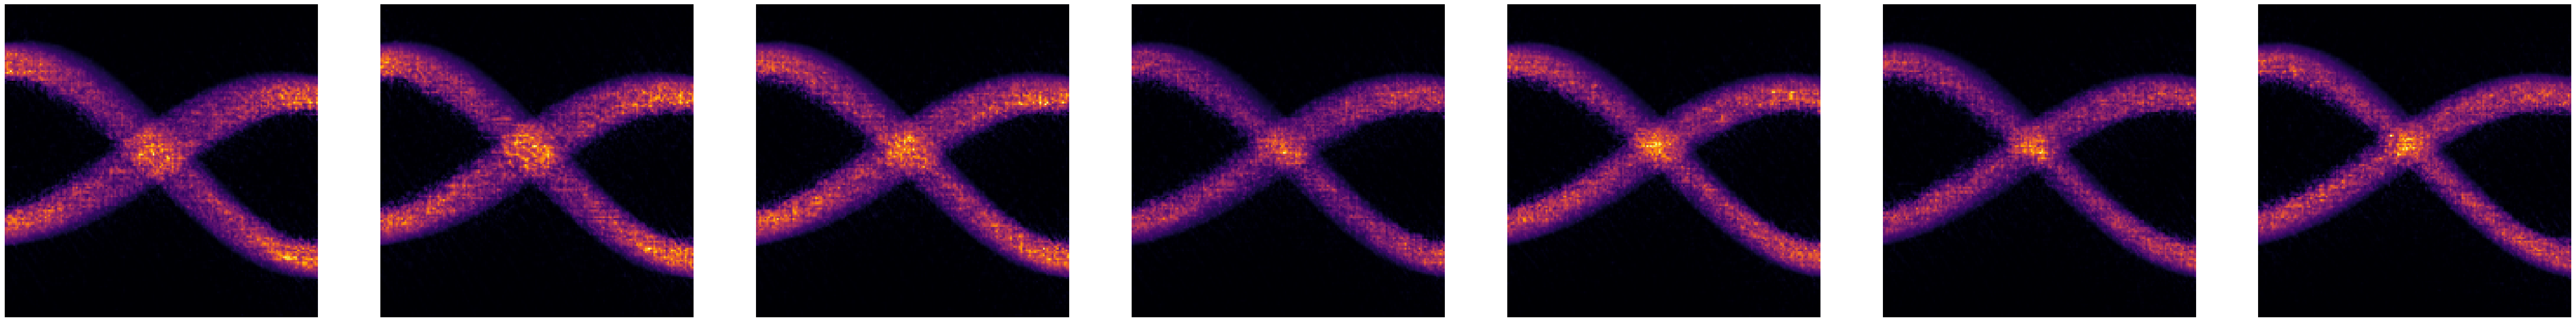

{'run_mode': 'train', 'device': 'cuda', 'num_examples': -1, 'act_sino_scale': 0.342, 'act_recon1_scale': 3.35, 'act_recon2_scale': 1.998, 'act_image_scale': 1, 'atten_image_scale': 308.335, 'atten_sino_scale': 39.187140258382726, 'augment': ('SI', True), 'shuffle': True, 'num_epochs': 100, 'load_state': True, 'save_state': False, 'offset': 0, 'show_times': False, 'sample_division': 1, 'train_display_step': 100, 'train_report_eval': False}


In [7]:
indexes = [13, 14, 15, 16, 17, 18, 19]

act_sino = torch.from_numpy(np.load(os.path.join(paths['data_dirPath'], 'train-highCountSino-180x180.npy'), mmap_mode='r'))[indexes,1,:,:].unsqueeze(dim=1)*settings['act_sino_scale']
atten_sino = torch.from_numpy(np.load(os.path.join(paths['data_dirPath'], 'train-attenSino-180x180.npy'), mmap_mode='r'))[indexes,0,:,:].unsqueeze(dim=1)*settings['atten_sino_scale']

show_multiple_matched_tensors(act_sino, atten_sino)
show_single_unmatched_tensor(act_sino+atten_sino)
print(settings)

## On the fly

In [8]:
# --- Refresh Repository ---
refresh_repo(IN_COLAB, local_repo_path=local_repo_dirPath)

visualize_sinogram_alignment(
    paths,
    settings,
    num_examples=10,
    scale_num_examples=None,  # Set to a large number to get an accurate scale
    start_index=600,
    randomize=True,
    random_seed=1,
    fig_size=3,
    cmap='inferno',
    circle=False,
    theta_type='symmetrical',  # 'speed' matches pooled angular sampling
    # Unified resize/pad options (applied to both activity and attenuation)
    sino_resize_type='bilinear',
    sino_pad_type='zeros',
    sino_init_vert_cut=320,
    vert_pool_size=1,
    horiz_pool_size=1,
    bilinear_intermediate_size=180,
    sino_size=256,
    # Attenuation generation options
    atten_creation_pool_size=1,
 )

NameError: name 'local_repo_dirPath' is not defined

# Visualizations

## Set Data

In [29]:
outputs_to_plot=['act_image', 'cnn_output','recon1','recon2']
display='radial'
device = "cpu"

if display=='train':
    act_sino_array_name = 'train-highCountSino-382x513.npy'
    act_image_array_name ='train-actMap.npy'
    atten_sino_array_name = 'train-attenSino-382x513.npy'
    atten_image_array_name = 'train-attenMap.npy'    
    recon1_name = 'train-highCountImage.npy'
    recon2_name = 'train-obliqueImage.npy'
    indexes = [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
    #indexes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    fig_size = 1.8
if display=='test':
    act_sino_array_name = 'test-highCountSino-382x513.npy'
    act_image_array_name ='test-actMap.npy'
    atten_sino_array_name = 'test-attenSino-382x513.npy'
    atten_image_array_name = 'test-attenMap.npy'
    recon1_name = 'test-highCountImage.npy'
    recon2_name = 'test-obliqueImage.npy'
    #indexes = [1200, 1300, 1400]
    indexes = [1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
    #indexes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    fig_size = 1.8
elif display=='NEMA':
    act_sino_array_name = 'QA-NEMA-highCountSino-382x513.npy'
    act_image_array_name ='QA-NEMA-actMap.npy'
    atten_sino_array_name = 'QA-NEMA-attenSino-382x513.npy'
    atten_image_array_name = 'QA-NEMA-attenMap.npy'
    recon1_name = 'QA-NEMA-highCountImage.npy'
    recon2_name = 'QA-NEMA-obliqueImage.npy'
    hot_mask_name = 'QA-NEMA-hotMask_17mm.npy'
    back_mask_name = 'QA-NEMA-backMask_17mm.npy'
    indexes = [13, 14, 15, 16, 17, 18, 19]
    hot_mask = torch.from_numpy(np.load(os.path.join(paths['data_dirPath'], hot_mask_name), mmap_mode='r'))[indexes]
    back_mask = torch.from_numpy(np.load(os.path.join(paths['data_dirPath'], back_mask_name), mmap_mode='r'))[indexes]
    fig_size = 1.8
elif display=='axial':
    act_sino_array_name = 'QA-Axial-highCountSino-382x513.npy'
    act_image_array_name ='QA-Axial-actMap.npy'
    atten_sino_array_name = 'QA-Axial-attenSino-382x513.npy'
    atten_image_array_name = 'QA-Axial-attenMap.npy'
    recon1_name = 'QA-Axial-highCountImage.npy'
    recon2_name = 'QA-Axial-obliqueImage.npy'
    indexes = [5, 10, 15, 20, 25, 30]
    fig_size = 1.8
elif display=='radial':
    act_sino_array_name = 'QA-Radial-highCountSino-382x513.npy'
    act_image_array_name ='QA-Radial-actMap.npy'
    atten_sino_array_name = 'QA-Radial-attenSino-382x513.npy'
    atten_image_array_name = 'QA-Radial-attenMap.npy'
    recon1_name = 'QA-Radial-highCountImage.npy'
    recon2_name = 'QA-Radial-obliqueImage.npy'
    indexes = [5, 15, 25]
    fig_size = 2.5
elif display=='pinwheel':
    act_sino_array_name = 'QA-Pinwheel-highCountSino-382x513.npy'
    act_image_array_name ='QA-Pinwheel-actMap.npy'
    atten_sino_array_name = 'QA-Pinwheel-attenSino-382x513.npy'
    atten_image_array_name = 'QA-Pinwheel-attenMap.npy'
    recon1_name = 'QA-Pinwheel-highCountImage.npy'
    recon2_name = 'QA-Pinwheel-obliqueImage.npy'
    indexes = [5, 15, 25]
    fig_size = 2.5
elif display=='mixed':
    act_sino_array_name = 'train-highCountSino-382x513.npy'
    act_image_array_name ='train-actMap.npy' 
    recon1_name = 'train-highCountImage.npy'
    recon2_name = 'train-obliqueImage.npy'
    atten_sino_array_name = 'QA-Radial-attenSino-382x513.npy'
    atten_image_array_name = 'QA-Radial-attenMap.npy'
    indexes = [5, 10, 15, 20, 25, 30]
    fig_size = 1.8

## 256x256 Grokking?

In [ ]:
checkpoint_name = 'checkpoint-ACT-256-largePadSino-fill_1-tunedSSIM-300epochs'
network_type='ACT'

config_ACT_SI ={ # 256x256, bilinear intemediate size = 180, tuned for SSIM, pad_type='sinogram', fill enforced to =1
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 1,
  "SI_gen_final_activ": None,
  "SI_gen_hidden_dim": 15,
  "SI_gen_mult": 2.8577974008839018,
  "SI_gen_neck": "medium",
  "SI_gen_z_dim": 1824,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "instance",
  "SI_learnedScale_init": 4.0327009143861074,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 2.9521606233259443,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 7,
  "gen_b1": 0.6207299459912765,
  "gen_b2": 0.5773966392271939,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.00026018975910785543,
  "gen_sino_channels": 3,
  "gen_sino_size": 256,
  "network_type": "ACT",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, network_type,
                  config_ACT_SI, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = atten_image_array_name,
                  atten_sino_array_name = atten_sino_array_name,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='bilinear',
                  sino_pad_type='sinogram',
                  image_pad_type='zeros',
                  sino_init_vert_cut=300,
                  vert_pool_size=1,
                  horiz_pool_size=1,
                  bilinear_intermediate_size=180)

act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']

show_single_unmatched_tensor(act_sino[0:2], fig_size=30)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)


print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)
print('SSIM (FORE):', SSIM_score2)
print('SSIM (Oblique):', SSIM_score3)
if display=='NEMA':
    CRC_score = ROI_NEMA_hot(act_image, recon2, hot_mask, back_mask)
    print('CRS (Recon2):', CRC_score)   

cnn_256=cnn_output


## 256x256, FROZEN_COUNTERFLOW

Shape: torch.Size([3, 1, 180, 180]) // Min: 0.0 // Max: 16.09766960144043 // Mean: 6.193131446838379 // Mean Sum (per image): 200657.45833333334 // Sum (a single image): 200657.453125
Shape: torch.Size([3, 1, 180, 180]) // Min: -3.3642630577087402 // Max: 74.34527587890625 // Mean: 18.948041915893555 // Mean Sum (per image): 613916.5833333334 // Sum (a single image): 606408.25
Shape: torch.Size([3, 1, 180, 180]) // Min: 5.856290809678489e-22 // Max: 23.687320709228516 // Mean: 6.310999393463135 // Mean Sum (per image): 204476.375 // Sum (a single image): 205352.71875
Shape: torch.Size([3, 1, 180, 180]) // Min: 0.0 // Max: 31.4218807220459 // Mean: 5.7331037521362305 // Mean Sum (per image): 185752.5625 // Sum (a single image): 185573.15625
Shape: torch.Size([3, 1, 180, 180]) // Min: 0.0 // Max: 59.2003173828125 // Mean: 31.713281631469727 // Mean Sum (per image): 1027510.3333333334 // Sum (a single image): 1027510.375


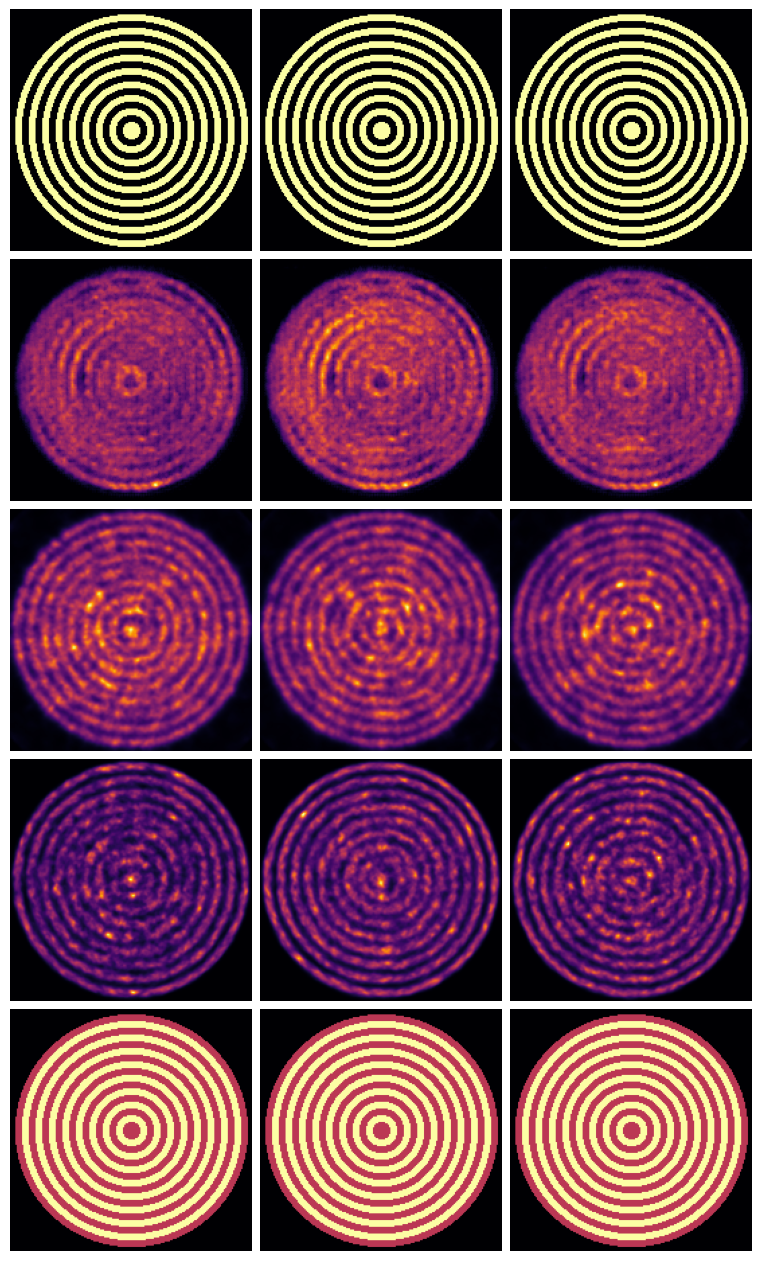

TypeError: show_multiple_commonmap_tensors() got an unexpected keyword argument 'figsize'

In [34]:
checkpoint_name = 'checkpoint-FROZEN_COUNTERFLOW-256-untuned-100epochs'
network_type='FROZEN_COUNTERFLOW'
outputs_to_plot=['act_image', 'cnn_output','recon1','recon2', 'atten_image']

#atten_image_array_name = 'QA-Radial-attenMap.npy'
atten_image_array_name = 'QA-Radial-attenMap-2xWater.npy'
#atten_image_array_name = 'QA-Radial-attenMap-swappedLACs.npy'


config_FROZEN_COUNTERFLOW= { # SAMPLE
  "FROZEN_IS_alpha_min": -1,
  "FROZEN_IS_dropout": False,
  "FROZEN_IS_exp_kernel": 3,
  "FROZEN_IS_fixedScale": 1,
  "FROZEN_IS_gen_fill": 0,
  "FROZEN_IS_gen_final_activ": None,
  "FROZEN_IS_gen_hidden_dim": 15,
  "FROZEN_IS_gen_mult": 3.3144387875060906,
  "FROZEN_IS_gen_neck": "medium",
  "FROZEN_IS_gen_z_dim": 1835,
  "FROZEN_IS_half_life_examples": -1,
  "FROZEN_IS_layer_norm": "group",
  "FROZEN_IS_learnedScale_init": 18.411171440894215,
  "FROZEN_IS_normalize": False,
  "FROZEN_IS_output_scale_lr_mult": 1.7607516297239543,
  "FROZEN_IS_pad_mode": "zeros",
  "FROZEN_IS_skip_mode": "none",
  "FROZEN_IS_stats_criterion": -1,
  "FROZEN_batch_base2_exponent": 6,
  "FROZEN_gen_b1": 0.17828464968859092,
  "FROZEN_gen_b2":  0.22254220083596676,
  "FROZEN_gen_image_channels": 1,
  "FROZEN_gen_image_size": 180,
  "FROZEN_gen_lr": 0.00011584402663085701,
  "FROZEN_gen_sino_channels": 1,
  "FROZEN_gen_sino_size": 256,
  "FROZEN_network_type": "ATTEN",
  "FROZEN_sup_base_criterion": "MSELoss",
  "FROZEN_train_SI": False,
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": None,
  "SI_gen_hidden_dim": 15,
  "SI_gen_mult": 3.3144387875060906,
  "SI_gen_neck": "medium",
  "SI_gen_z_dim": 1835,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "group",
  "SI_learnedScale_init": 18.411171440894215,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 1.7607516297239543,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 6, #6
  "gen_b1": 0.17828464968859092,
  "gen_b2": 0.22254220083596676,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.00011584402663085701,
  "gen_sino_channels": 3,
  "gen_sino_size": 256,
  "network_type": "FROZEN_COUNTERFLOW",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, network_type,
                  config_FROZEN_COUNTERFLOW, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = atten_image_array_name,
                  atten_sino_array_name = atten_sino_array_name,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='bilinear',
                  sino_pad_type='sinogram',
                  image_pad_type='zeros',
                  sino_init_vert_cut=300,
                  vert_pool_size=1,
                  horiz_pool_size=1,
                  bilinear_intermediate_size=180)

act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']
atten_image = tensors['atten_image_tensor']

show_single_unmatched_tensor(cnn_output[2:4], fig_size=fig_size)
show_single_unmatched_tensor(cnn_output[2:4] + act_image[2:4], fig_size=fig_size)
show_single_unmatched_tensor(cnn_output[2:4] + atten_image[2:4], fig_size=fig_size)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)

print(fig_size)

## 256x256, CONCAT

In [ ]:
checkpoint_name = 'checkpoint-CONCAT-256-largePadSino-tunedSSIM-90epochs'
network_type='CONCAT'

config_CONCAT = {
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 4,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": "LeakyReLU",
  "SI_gen_hidden_dim": 29,
  "SI_gen_mult": 2.031696618359278,
  "SI_gen_neck": "medium",
  "SI_gen_z_dim": 958,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "instance",
  "SI_learnedScale_init": 6.099856735304703,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 2.166354001308141,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 5,
  "gen_b1": 0.3706466944358945,
  "gen_b2": 0.4364991709587488,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.0004300814461678685,
  "gen_sino_channels": 4,
  "gen_sino_size": 256,
  "network_type": "CONCAT",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}


tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, network_type,
                  config_CONCAT, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = None,
                  atten_sino_array_name = atten_sino_array_name,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='bilinear',
                  sino_pad_type='sinogram',
                  image_pad_type='zeros',
                  sino_init_vert_cut=300,
                  vert_pool_size=1,
                  horiz_pool_size=1,
                  bilinear_intermediate_size=180)

act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']

show_single_unmatched_tensor(act_sino[0:2], fig_size=30)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)


print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)
print('SSIM (FORE):', SSIM_score2)
print('SSIM (Oblique):', SSIM_score3)

cnn_256=cnn_output

## 256x256, wide sinogram padding

In [ ]:
#checkpoint_name = 'checkpoint-ACT-256-largePadSino-tunedSSIM-100epochs'
checkpoint_name = 'checkpoint-ACT-256-largePadSino-tunedSSIM-100epochs'

config_ACT_SI = { # 256x256, tuned SSIM, pad_type='sinogram', bilinear intermediate size = 180
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": None,
  "SI_gen_hidden_dim": 15,
  "SI_gen_mult": 3.3144387875060906,
  "SI_gen_neck": "medium",
  "SI_gen_z_dim": 1835,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "group",
  "SI_learnedScale_init": 18.411171440894215,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 1.7607516297239543,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 6,
  "gen_b1": 0.17828464968859092,
  "gen_b2": 0.22254220083596676,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.00011584402663085701,
  "gen_sino_channels": 3,
  "gen_sino_size": 256,
  "network_type": "ACT",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, 'ACT',
                  config_ACT_SI, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = None,
                  atten_sino_array_name = None,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='bilinear',
                  sino_pad_type='sinogram',
                  image_pad_type='zeros',
                  sino_init_vert_cut=300,
                  vert_pool_size=1,
                  horiz_pool_size=1,
                  bilinear_intermediate_size=180)

act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']

show_single_unmatched_tensor(act_sino[0:2], fig_size=30)


SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)


print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)
print('SSIM (FORE):', SSIM_score2)
print('SSIM (Oblique):', SSIM_score3)



cnn_256=cnn_output

## 288x288, pooled, narrow zeros padding

In [ ]:
checkpoint_name = 'checkpoint-ACT-288-padZeros-tunedSSIM-100epochs'

config_ACT_SI = { # 288x288, tuned SSIM, pad_type='zeros', interemediate size = None, horiz_pool=1, vert_pool=1
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": "LeakyReLU",
  "SI_gen_hidden_dim": 10,
  "SI_gen_mult": 1.5012782419950113,
  "SI_gen_neck": "narrow",
  "SI_gen_z_dim": 872,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "instance",
  "SI_learnedScale_init": 7.305980552864529,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 1.6943444827125673,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "conv",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 7,
  "gen_b1": 0.3600790033157822,
  "gen_b2": 0.6033159868492163,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.0024018267054557695,
  "gen_sino_channels": 3,
  "gen_sino_size": 288, # 288
  "network_type": "ACT",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, 'ACT',
                  config_ACT_SI, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = None,
                  atten_sino_array_name = None,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='pool',
                  sino_pad_type='zeros',
                  image_pad_type='zeros',
                  sino_init_vert_cut=320,
                  vert_pool_size=1,
                  horiz_pool_size=2,
                  bilinear_intermediate_size=161)

act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']


show_single_unmatched_tensor(act_sino[0:2], fig_size=30)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)

print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)
print('SSIM (FORE):', SSIM_score2)
print('SSIM (Oblique):', SSIM_score3)

cnn_288=cnn_output

## 180x180, bilinear, narrow zeros padding

In [ ]:
checkpoint_name = 'checkpoint-ACT-180-padZeros-tunedSSIM-100epochs'

config_ACT_SI = { # 180x180, tuned SSIM, pad_type='zeros', bilinear_intermediate_size = 161, horiz_pool=2, vert_pool=1
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 4,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": "LeakyReLU",
  "SI_gen_hidden_dim": 11,
  "SI_gen_mult": 2.0282722914428213,
  "SI_gen_neck": "narrow",
  "SI_gen_z_dim": 584,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "instance",
  "SI_learnedScale_init": 10.553559972734485,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 8.240938610220685,
  "SI_pad_mode": "replicate",
  "SI_skip_mode": "conv",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 5,
  "gen_b1": 0.4495215605123463,
  "gen_b2": 0.15053718115803394,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.0003521542451328137,
  "gen_sino_channels": 3,
  "gen_sino_size": 180,
  "network_type": "ACT",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, 'ACT',
                  config_ACT_SI, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = act_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = None,
                  atten_sino_array_name = None,
                  recon1_array_name = recon1_name,
                  recon2_array_name = recon2_name,
                  sino_resize_type='bilinear',
                  sino_pad_type='zeros',
                  image_pad_type='zeros',
                  sino_init_vert_cut=320,
                  vert_pool_size=1,
                  horiz_pool_size=2,
                  bilinear_intermediate_size=161)


act_sino = tensors['act_sino_tensor']
act_image = tensors['act_image_tensor']
recon1 = tensors['recon1_tensor']
recon2 = tensors['recon2_tensor']


show_single_unmatched_tensor(act_sino[0:2], fig_size=30)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score2 = calculate_metric(recon1, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)
SSIM_score3 = calculate_metric(recon2, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)

print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)
print('SSIM (FORE):', SSIM_score2)
print('SSIM (Oblique):', SSIM_score3)


cnn_180 = cnn_output

## 256x256, ATTEN, sino->image

In [ ]:
checkpoint_name = 'checkpoint-ATTEN_SI-256-largePadSino-untuned-25epochs'
network_type='ATTEN'

config_ATTEN_SI= { # SAMPLE
  "SI_alpha_min": -1,
  "SI_dropout": False,
  "SI_exp_kernel": 3,
  "SI_fixedScale": 1,
  "SI_gen_fill": 0,
  "SI_gen_final_activ": None,
  "SI_gen_hidden_dim": 15,
  "SI_gen_mult": 3.3144387875060906,
  "SI_gen_neck": "medium",
  "SI_gen_z_dim": 1835,
  "SI_half_life_examples": -1,
  "SI_layer_norm": "group",
  "SI_learnedScale_init": 18.411171440894215,
  "SI_normalize": False,
  "SI_output_scale_lr_mult": 1.7607516297239543,
  "SI_pad_mode": "zeros",
  "SI_skip_mode": "none",
  "SI_stats_criterion": -1,
  "batch_base2_exponent": 6,
  "gen_b1": 0.17828464968859092,
  "gen_b2": 0.22254220083596676,
  "gen_image_channels": 1,
  "gen_image_size": 180,
  "gen_lr": 0.00011584402663085701,
  "gen_sino_channels": 1,
  "gen_sino_size": 256,
  "network_type": "ATTEN",
  "sup_base_criterion": "MSELoss",
  "train_SI": True
}

tensors, cnn_output = PlotPhantomRecons(indexes, checkpoint_name, network_type,
                  config_ATTEN_SI, paths, fig_size, device, settings,
                  outputs_to_plot = outputs_to_plot,
                  act_image_array_name = atten_image_array_name,
                  act_sino_array_name = act_sino_array_name,
                  atten_image_array_name = atten_image_array_name,
                  atten_sino_array_name = atten_sino_array_name,
                  recon1_array_name = None,
                  recon2_array_name = None,
                  sino_resize_type='bilinear',
                  sino_pad_type='sinogram',
                  image_pad_type='zeros',
                  sino_init_vert_cut=300,
                  vert_pool_size=1,
                  horiz_pool_size=1,
                  bilinear_intermediate_size=180)

act_sino = tensors['atten_sino_tensor']
act_image = tensors['atten_image_tensor']

show_single_unmatched_tensor(act_sino[0:2], fig_size=3)

SSIM_score1 = calculate_metric(cnn_output, act_image, SSIM, return_dataframe=False, label='default', crop_factor=1)


print("=====================")
print('SSIM (CNN):', SSIM_score1)
if display=='NEMA':
    CRC_score =   ROI_NEMA_hot(act_image, cnn_output, hot_mask, back_mask)
    print('CRS (CNN):', CRC_score)

cnn_256=cnn_output

## Compare Recons

In [ ]:
# Resize ground truth to 161 for comparison
act_image=act_image_180
cnn_output=cnn_output_180

import torch
import torch.nn.functional as F

# Resize ground truth to 161×161
act_image_resized = F.interpolate(act_image, size=(161, 161), mode='bilinear', align_corners=False)

# Pad back to 180×180 (centered, with zeros on edges)
pad_size = (180 - 161) // 2
act_image_padded = F.pad(act_image_resized, (pad_size, pad_size, pad_size, pad_size), mode='constant', value=0)

# Now compare visually at same size
show_single_unmatched_tensor(cnn_output[0:2], fig_size=4)
print("CNN output (180×180)")

show_single_unmatched_tensor(act_image_padded[0:2], fig_size=4)
print("Ground truth resized to 161×161 then padded to 180×180")

# Network Notes

## 256X25, Grokking?

traing set (SSIM): 0.9260909110307695

training set (SSIM): 0.8962109171681936

NEMA (SSIM) 0.8079071172646114

## 256x256, Frozen Counterflow

test set (SSIM): 0.9320924265517129 

training set (SSIM): 0.9104165567292107

NEMA (SSIM): 0.7954177600996835

## 256X256, Concatenated (ACT+ATTEN)

training set (SSIM): 0.9194957282808092

test set  (SSIM): 0.9063458773824903

NEMA (SSIM): 0.823534403528486 (CNN): 

## 256X256 Network, wide sinogram padding

### 100 epochs:

training set (SSIM): 0.9145165756344795

test set (SSIM): 0.8924144506454467

NEMA (SSIM): 0.8422211110591888

NEMA (CRS): 5.4327197

### 10 epochs:

training set (SSIM): 0.8859575778245926

test set (SSIM): 0.8461712673306464

NEMA (SSIM): 0.8121777496167591

NEMA (CRS): 7.2759275

## 288x288, pooled, narrow zeros padding
Sinograms were created by vertical cropping to size 288, then pooling to size 257. Finally it was zero padded to width of 288

SSIM for some sample phantoms:

training set (SSIM): 0.8996513456106185

test set (SSIM): 0.8711688712239266

NEMA (SSIM): 0.7882774812834603

NEMA (CRS): -8.62283

## 180x180, bilinear, narrow zeros padding
Sinograms were created by vertical cropping to size 320, then resizing bilinearly to 161x161. Finally, it was zero padded to 180x180. Padding fraction was the same as 288x288 network.

training set (SSIM): 0.8836602836847306

test set (SSIM): 0.87947369068861

NEMA (SSIM): 0.8155272219862257

NEMA (CRS): 32.660236

## 256x256, Attenuation, sino->image

training (SSIM): 0.9756443401177725

test set (SSIM): 0.9684655484226016

NEMA (SSIM): 0.979976251721382

# Reload Package After Code Changes

If you modify package code, use this cell to reload without restarting the kernel:

In [33]:
# Reload package after making code changes
reload_package()  # Reloads from local repo

# Or use refresh_repo() to pull from git and reinstall
#refresh_repo(IN_COLAB=IN_COLAB, force_fresh_clone=True)

# Rebuild dictionaries with updated code
all_dicts = build_all_dicts(params)
config = all_dicts['config']
paths = all_dicts['paths']
settings = all_dicts['settings']

print("✅ Package reloaded and dictionaries rebuilt!")

🔄 Reloading FlexCNN_for_Medical_Physics package...
✨ Injecting all symbols into global namespace...
✅ Reload complete: 252 symbols updated.
[SETUP_SETTINGS DEBUG - TRAIN] Setting augment to: ('SI', True)

[AUGMENT DEBUG] run_mode=train, network_type=ACT
[AUGMENT DEBUG] settings['augment']=('SI', True)
[AUGMENT DEBUG] Expected augment from params: train_augment=('SI', True)

✅ Package reloaded and dictionaries rebuilt!


# Run Pipeline

In [ ]:
# Run the pipeline (function available from environment setup)
run_pipeline=False
if run_pipeline=True:

    run_pipeline(
        config=config,
        paths=paths,
        settings=settings,
        tune_opts=tune_opts,
        base_dirs=base_dirs,
        test_opts=test_opts,
    )